# Tranining model

There are many model to be trained in this chapter:

- Use the text feature to predict the price of the product.
- Find which factors influnce the price of the product most.
- Use the product factors to predict the ranking of the product

In [36]:
%matplotlib inline 
import numpy as np
import pandas as pd # for data analysis
import matplotlib.pyplot as plt # for plotting
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LogisticRegressionCV, RidgeCV
from sklearn.metrics import classification_report

In [2]:
pens_df = pd.read_csv("clean_fountain_pen_dataset.csv").drop(["Unnamed: 0"],axis=1)
pens_df.head()

,url,Product_Code,Name,In_Stock,Price,Nib_Size,Brand,Color,Demonstrator,Body_Material,...,Max_Ink_Capacity_Converter,Max_Ink_Capacity_Eyedropper,Cap_Rotations,created_at,description,featured_image,images,published_at,clean_description,Series
0,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-01-1,Platinum Preppy Fountain Pen - Black,True,5.00,"Extra-Fine, Fine, Medium",Platinum,Black,Yes,Resin,...,0.98,4.33,NaN,2018-05-02 10:28:05-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy
1,https://www.gouletpens.com/collections/all-fou...,PN91111,Pilot Metropolitan Fountain Pen - Black Plain,True,23.99,"Fine, Medium, 1.0mm Stub",Pilot,Black,No,Lacquered metal,...,1.30,NaN,NaN,2018-05-02 10:28:13-04:00,"\nA fantastic value from Pilot, the Metropolit...",//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,fantastic value favorite first black metal bod...,Metropolitan
2,https://www.gouletpens.com/collections/all-fou...,TW-M7445300,TWSBI ECO Fountain Pen - Clear,True,28.99,"Extra-Fine, Fine, Medium, Broad, 1.1mm Stub",TWSBI,Clear,Yes,Resin,...,NaN,NaN,1.00,2018-05-02 10:28:24-04:00,\r\n The TW...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,boast incredible value piston filling system a...,ECO
3,https://www.gouletpens.com/collections/all-fou...,N15021,Noodler's Ahab Flex Fountain Pen - Clear,True,23.00,Flex,Noodler's,Clear,Yes,Resin,...,NaN,6.17,2.25,2018-05-02 10:25:05-04:00,\r\n The No...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,noodler 's ahab flex feature steel flexible 6 ...,Ahab Flex
4,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-03-1,Platinum Preppy Fountain Pen - Blue,True,4.98,"Extra-Fine, Fine, Medium",Platinum,Blue,Yes,Resin,...,0.98,4.33,NaN,2018-05-02 10:28:06-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy


## *Model A*: use the text feature in predicting the price of the product

I want to explore whether the text message does show the pattern of setting price tag. Most of time when we plan to buy a product, we want to check the product discription to see if its really worth to buy. Does the product discription really tell us something important, distinguishable from other product? I doubt this as I always have trouble to buy a product and may hesitate to make the final decision. So I want to build a model to verify it.

In [30]:
pens_df[["Price","clean_description"]].sample(5)

,Price,clean_description
541,68.0,usa back exquisite ever rodeo drive collection...
600,316.0,new feature dark blue five-sided faceted resin...
557,750.0,maki-e created collaboration maki-e artist kok...
377,27.0,frosted sport pocket-sized posted transforms f...
208,56.0,new series combine vintage appeal modern bold ...


### *Response Variable Choice 1*: continuous variable

The price could explicitly give the intuition of how much the product worths.

In [3]:
y = pens_df.Price[pens_df.clean_description.notnull()]

### *Response Variable Choice 2*: discrete variable

The price can be seperated as affordable and unaffordable sometimes, or more intutively with high and low price. That makes sense when we have limited budget.

With domain knowledge, pen lovers always treat the $200 as the boundary between affordable and unaffordable pens.

In [4]:
y = np.where(pens_df.Price < 200, 1, 0)[pens_df.clean_description.notnull()]

### *Explanatory Variable Choice 1*: use the count of each word to build the feature vector

All the stopwords and the feature words for each individual pen have been removed. The count of each word could implicate the importance of the text. 

In [33]:
clean_text = pens_df.clean_description[pens_df.clean_description.notnull()]
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 2*: use the tfid features of each word to build the feature vector

The importance of the words will increase while the frequency of words in each text increase. But the importance is also limited by the frequency of word in all the text together. This inverse document frequency method can avoid the penalty of same words occur in multiple texts.

In this dataset, this could effectively lower the occur of technical words of product and concentrate more on the unique discription of each product.

In [22]:
clean_text = pens_df.clean_description[pens_df.clean_description.notnull()]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 3*: use PCA to reduce the dimension of the frequency count feature vector

As the frequency count data feature could be highly correlated, we could use PCA to find the principle components and recompute the feature vector to get less correlated data. This is useful for further logistic regression analysis as the logitstic regression can't seperate the correlation of the different predictors as Lasso or Ridge.

In [24]:
clean_text = pens_df.clean_description[pens_df.clean_description.notnull()]
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X.toarray())
print(X.shape)
print(X_pca.shape)
X = X_pca

(653, 3449)
(653, 86)


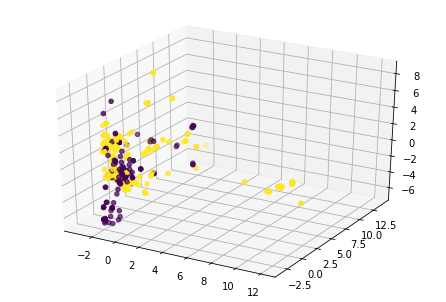

In [37]:
## Try projection with 3D PCA
clean_text = pens_df.clean_description[pens_df.clean_description.notnull()]
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:,0], X_pca[:,1],X_pca[:,2], c=y)

### Split the data

To use train-validate-test validation could cost lots of data in the validate data and test data. The dataset is quite a small dataset. So it's more reasonable to use cross validation method to reuse the data many times to get more information and more precise result.

In [25]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
# val_X, test_X, val_y, test_y = train_test_split(test_X,test_y,test_size=0.5,random_state=1)
# train_X.shape, val_X.shape, test_X.shape

### *Model Fitting Choice 1*: Ridge cross validation model

I ignored the exploration of the linear regression model, because its obvious that, in text data, there is some relation between the words. There should be some pattern such that some words always come after the certain other word. In the transformed feature vector of each text, this behaves as highly coefficients amount the different feature words predictors. So the variable of each predictor could very among different random states and also cause model overfitting.

So, for the continuous response, I choose the Ridge model to add penalty to the coefficient, suppress the co-linearity and get a better prediction.

In [63]:
ridge_reg = RidgeCV(cv=5)
ridge_reg.fit(train_X,train_y)
ridge_reg.score(test_X,test_y)

0.8282018183379529

### *Model Fitting Choice 2*: Lasso cross validation model

Different from the Ridge regression, Lasso uses l2 penalty(sum of squares) rather than l1 penalty(absolute value). So Lasso could compute zero coefficient. This property gives it the function to do predictors selection and slove model overfitting.

To check for model overfitting and reduce its effect, the Lasso regression should be applied.

In [64]:
lasso_reg = LassoCV(cv=5)
lasso_reg.fit(train_X,train_y)
lasso_reg.score(test_X,test_y)

0.8081049771887623

### *Model Fitting Choice 3*: Logistic regression cross validation model

If the response variable is a two-level categorical variable. Logistic regression is applied.

In [68]:
logistic_reg = LogisticRegressionCV(cv=5)
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

0.9694656488549618
              precision    recall  f1-score   support

   low_price       1.00      0.86      0.92        28
  high_price       0.96      1.00      0.98       103

   micro avg       0.97      0.97      0.97       131
   macro avg       0.98      0.93      0.95       131
weighted avg       0.97      0.97      0.97       131



### *Model Fitting Choice 3*: Logistic regression cross validation model with PCA components

Logistic regression can't handle the correlation between the different components. So using PCA to get principle component should get a better result.

In [32]:
logistic_reg = LogisticRegressionCV(cv=5,max_iter=1000)
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

0.9770992366412213
              precision    recall  f1-score   support

   low_price       0.96      0.93      0.95        28
  high_price       0.98      0.99      0.99       103

   micro avg       0.98      0.98      0.98       131
   macro avg       0.97      0.96      0.97       131
weighted avg       0.98      0.98      0.98       131

